In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

# Introduction

We have a lot of input features and many labels. The goal of this Notebook is to see if we can trim the number of input features based on an array of different processing methods. For this Notebook, I will look at the following relationships to determine whether an input feature is relevant:
- correlations
- feature importances
- feature ranking with recursive feature elimination
- Principle Component Analysis (PCA)

Another interesting thing to look at would be to see what output features (labels) we can reasonably expect a machine learning model to predict. For instance, it may be that we can only predict half of the avlanche bulletin's output fields.

# Read in data

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


# Data formatting, overall distributions

I go through some of these processing steps (with more printouts) in the Notebook on data distributions, so will not go through them here.

In [3]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# replace double underscores with single underscores
labeled_data.data.columns = [col.replace('__', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [col.replace('__', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS_problem_amount'] = labeled_data.label['CLASS_problem_amount'].astype(int)
labeled_data.label['CLASS_danger_level'] = labeled_data.label['CLASS_danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)
        
# below, we can try to make categorical variables in the labels numeric
# first for the emergency warning column
warning_dict = {'Ikke gitt':0,
                'Naturlig utløste skred':1}

labeled_data.label['CLASS_emergency_warning'] = labeled_data.label['CLASS_emergency_warning'].replace(warning_dict)

# and now for the class problems
problem1 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_1'].values))
problem2 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_2'].values))
problem3 = list(np.unique(labeled_data.label.loc[:, 'CLASS_problem_3'].values))

list_of_problems = sorted(list(np.unique(problem1 + problem2 + problem3)))
problems_dict = {'':0, 'drift-slab':1, 'glide':2, 'new-loose':3,
                 'new-slab':4, 'pwl-slab':5, 'wet-loose':6, 'wet-slab':7}

labeled_data.label['CLASS_problem_1'] = labeled_data.label['CLASS_problem_1'].replace(problems_dict)
labeled_data.label['CLASS_problem_2'] = labeled_data.label['CLASS_problem_2'].replace(problems_dict)
labeled_data.label['CLASS_problem_3'] = labeled_data.label['CLASS_problem_3'].replace(problems_dict)

regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [4]:
print(regions.shape)
print(labels.shape)

(13115, 245)
(13115, 69)


In [5]:
for column in labels.columns:
    #if(isinstance(labels[column].dtypes, np.int)):
    is_not_int = labels[column].dtype is not np.dtype(np.int64)
    is_not_float = labels[column].dtype is not np.dtype(np.float64)
    
    if(np.logical_and(is_not_int, is_not_float)):
        print(labels[column].dtypes, '     ', column)
    
### Need to find a way to pre-process cause and aspect columns ####

object       CLASS_drift-slab_cause
object       CLASS_glide_cause
object       CLASS_new-loose_cause
object       CLASS_new-slab_cause
object       CLASS_pwl-slab_cause
object       CLASS_wet-loose_cause
object       CLASS_wet-slab_cause
object       MULTI_drift-slab_aspect
object       MULTI_glide_aspect
object       MULTI_new-loose_aspect
object       MULTI_new-slab_aspect
object       MULTI_pwl-slab_aspect
object       MULTI_wet-loose_aspect
object       MULTI_wet-slab_aspect


# Correlation analysis

In [6]:
features_and_labels = features = pd.concat([regions, labels], axis=1)
features_and_labels.shape

(13115, 314)

In [7]:
# drop columns that include text, create correlations matrix
only_numeric = features_and_labels.select_dtypes(include='number')
correlations = only_numeric.corr()

# shorten the x axis to only the labels
keep_cols = [col for col in labels if col in correlations.columns]
drop_rows = list(set(correlations.columns) - set(keep_cols))
correlations = correlations.loc[drop_rows, keep_cols]

# there are some rows with only nan values, we can drop those here
empty_rows = [item for item in correlations.index if correlations.loc[item].isna().all() == True]
correlations.drop(empty_rows, inplace = True)

In [8]:
print(correlations.shape)

(183, 55)


**Another thing to try would be to drop all rows where the absolute value of the correlation is below 0.25 or 0.25, for all values. These input features probably don't need to be considered.**

In [9]:
np.sum([(abs(correlations.loc[idx, :].values) < 0.50).all() for idx in correlations.index])

97

In [10]:
weak_correlations = [(abs(correlations.loc[idx, :].values) < 0.50).all() for idx in correlations.index]
correlations.loc[weak_correlations, :].shape

(97, 55)

In [11]:
drop_weak = correlations.loc[weak_correlations, :].index.values
correlations.drop(drop_weak, inplace=True)
correlations.shape

(86, 55)

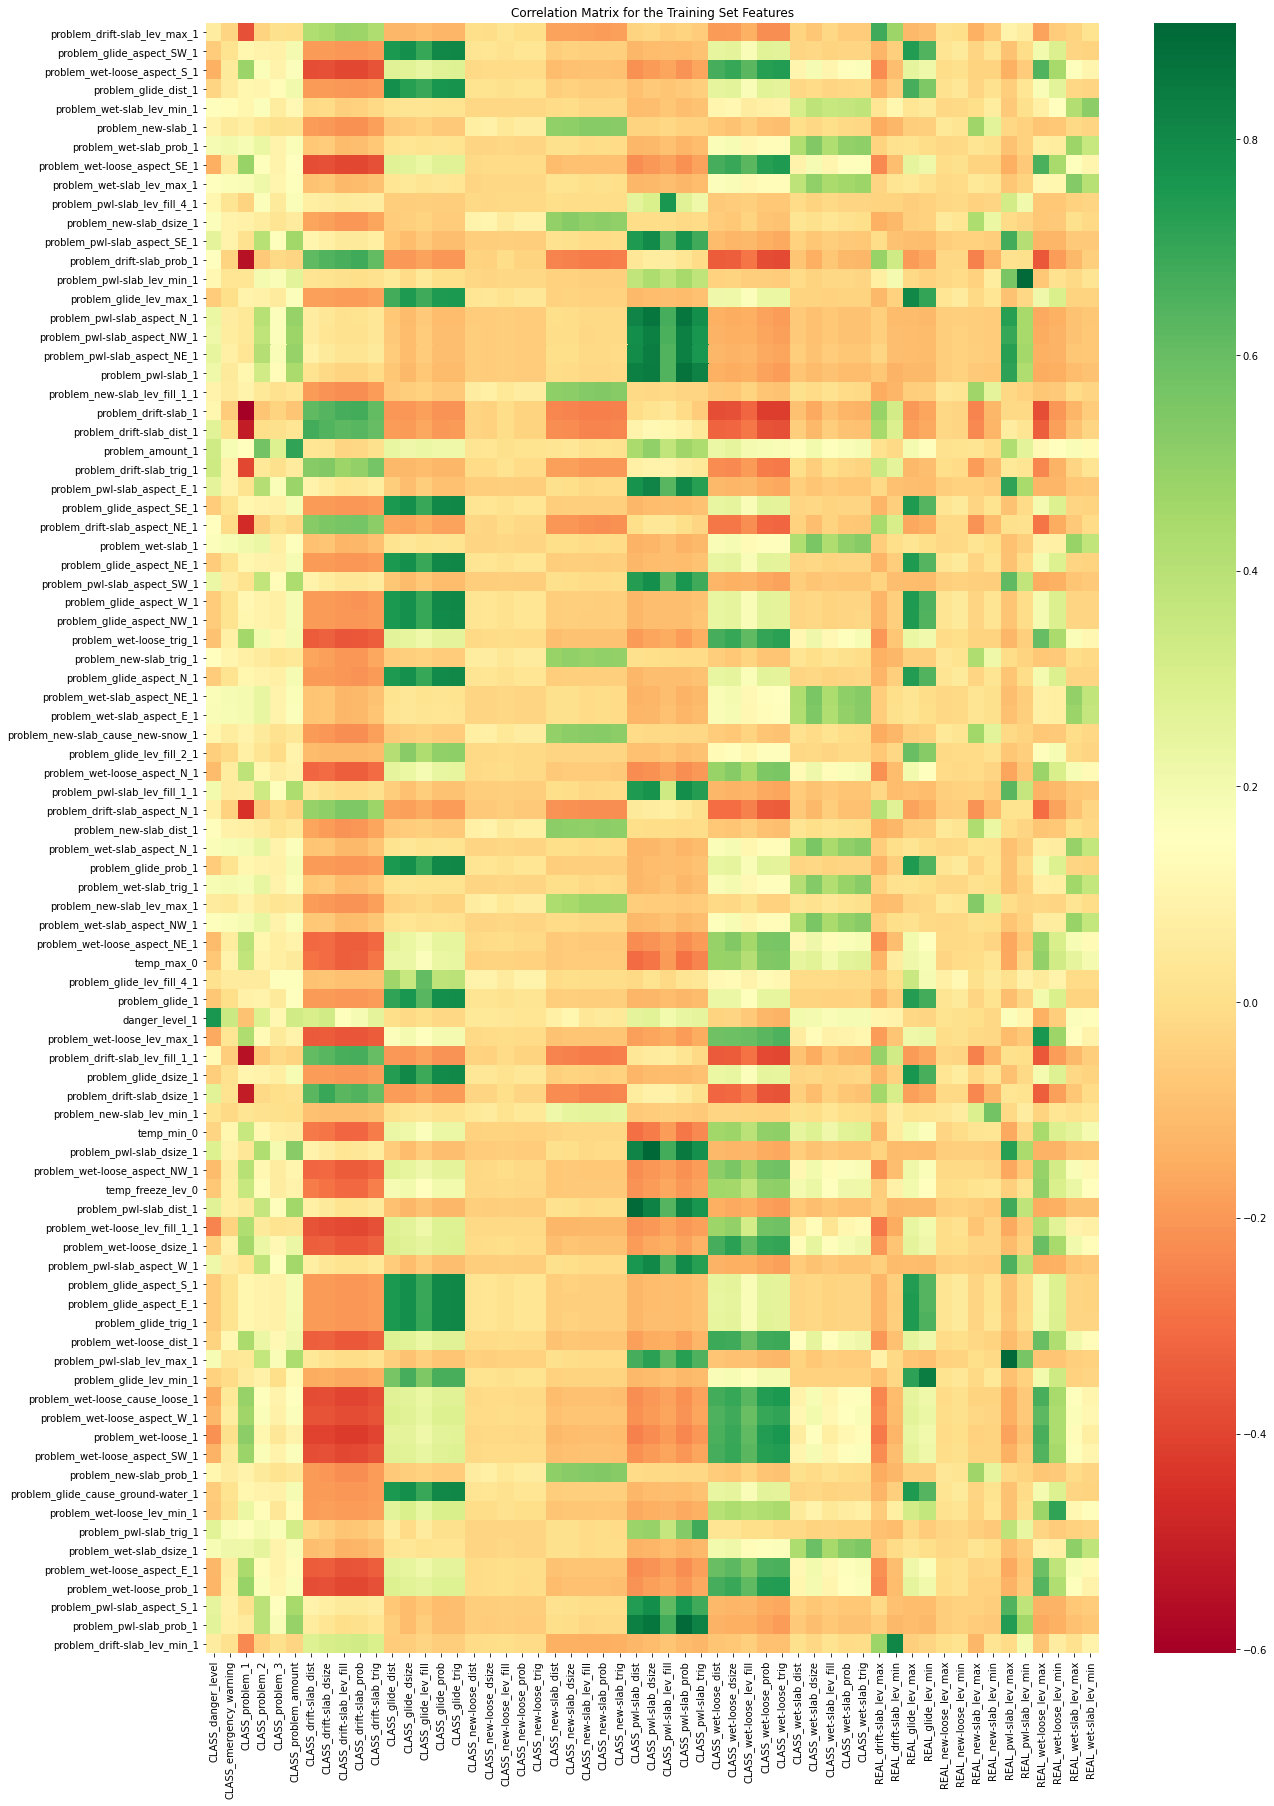

In [12]:
fig, ax = plt.subplots(figsize=(20, 30))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.index, cmap='RdYlGn', ax=ax)
ax.set_title('Correlation Matrix for the Training Set Features')

plt.show()

**So according to our correlation analysis, there are about 139 features out of the original 291 that are useful in predicting one or more of our labels. We can save those below and compare them with what features our other analysis find useful.**

In [13]:
keep_columns_correlations = list(correlations.index)
#keep_columns_correlations

# Principal Component Analysis

My goal for this section is to perform PCA on our input data as a means of dimensionality reduction. I want to see if there are any variables that explain some amount of shared variance (meaning that they contribute nothing extra to our analysis). If this is the case, we can drop those columns and save compute resources.

We can do this because Principle Components are orthogonal: this means that they should be completely uncorrelated with each other.

Thank you to these two excellent resources on how to compute the loadings matrix after doing PCA:
- https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html
- https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

In [14]:
# appply feature scaling
scaler = StandardScaler()

# fit and transform the data in one step
# now we move from a dataframe to a numpy array
scaled = pd.DataFrame(scaler.fit_transform(regions), columns=regions.columns, index=regions.index)
scaled.head()

,,danger_level_1,emergency_warning_1,problem_amount_1,problem_new-loose_1,problem_wet-loose_1,problem_new-slab_1,problem_drift-slab_1,problem_pwl-slab_1,problem_wet-slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-23,2.597059,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,2.351196,-0.674028,-0.525028
3034,2017-11-23,2.597059,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,2.351196,-0.674028,-0.525028
3003,2017-12-02,-1.530477,0.332556,-0.953027,-0.098478,-0.589482,-0.431643,0.923998,-0.709996,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,-0.424190,-0.617928,-0.425315,-0.674028,-0.525028
3007,2017-12-02,-0.154632,0.332556,0.707080,-0.098478,-0.589482,-0.431643,0.923998,1.009438,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,2.357435,-0.617928,2.351196,-0.674028,-0.525028
3009,2017-12-02,-0.154632,0.332556,0.707080,-0.098478,-0.589482,-0.431643,0.923998,1.009438,-0.329966,-0.234782,...,-0.272411,-0.262426,-0.066069,-0.246805,-0.496543,2.357435,-0.617928,2.351196,-0.674028,-0.525028


In [15]:
# fit and transform the data here, create principal components
pca = PCA()
pcs = pca.fit_transform(scaled)

# print the explained variance ratio of the first ten principal components
var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

print(var_ratio[:10])

[0.1351596  0.09355931 0.08943068 0.07949308 0.0684235  0.05768215
 0.02415697 0.01468531 0.01253461 0.01173157]


The Principal Components do not explain as much variance as we would like early on. It would be ideal if the first PC explained greater than 50% of the variance, but we don't reach that level until we keep around 10 components. Still, we can reduce the data set by over a third while still maintaining 95% of the explained variance.

In [16]:
# find the index where we cross 90% variance explained
# the first [0] moves from array to list object, the second isolates the first index
idx_90 = np.where(cumulative_var > 0.90)[0][0]

# for 95% variance explained
idx_95 = np.where(cumulative_var > 0.95)[0][0]

In [17]:
print('If we wanted to retain 90% of the variance explained, we would need to keep {} PCs.'.format(idx_90+1))

print('If we wanted to retain 95% of the variance explained, we would need to keep {} PCs.'.format(idx_95+1))

If we wanted to retain 90% of the variance explained, we would need to keep 59 PCs.
If we wanted to retain 95% of the variance explained, we would need to keep 73 PCs.


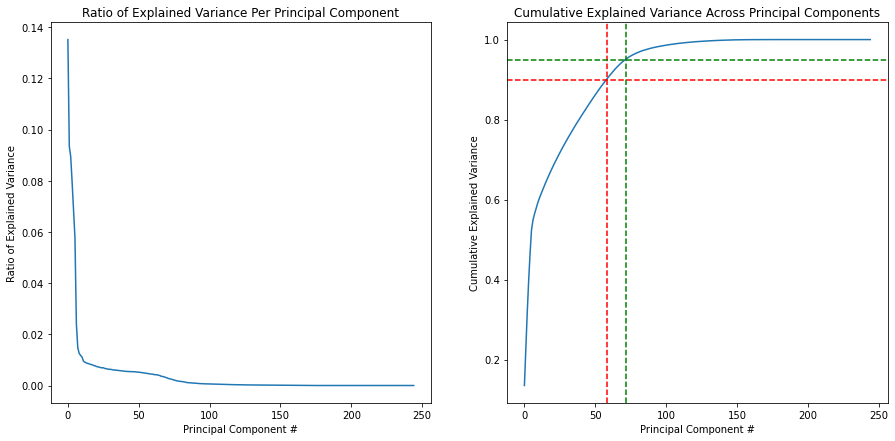

In [18]:
# investigate the variance accounted for by each principal component.
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(var_ratio)
ax[1].plot(cumulative_var)

ax[0].set_xlabel('Principal Component #')
ax[0].set_ylabel('Ratio of Explained Variance')
ax[0].set_title('Ratio of Explained Variance Per Principal Component')

ax[1].set_xlabel('Principal Component #')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Cumulative Explained Variance Across Principal Components')

# show where the number of pcs crosses a certain level of cumulative variance
ax[1].axhline(y=0.90, linestyle='--', color='r')
ax[1].axvline(x=idx_90, linestyle='--', color='r')

ax[1].axhline(y=0.95, linestyle='--', color='g')
ax[1].axvline(x=idx_95, linestyle='--', color='g')

plt.show()

In [19]:
# re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=idx_95+1)

#fit and transform the data here, create principal components
pcs = pca.fit_transform(scaled)

**"PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed."**

In [20]:
loadings = pd.DataFrame(pca.components_.T, index=regions.columns)
loadings

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
danger_level_1,-0.022479,-0.008791,0.054399,-0.003478,0.111719,0.039616,0.229460,-0.015946,-0.118503,-0.004705,...,0.005635,0.018744,0.084079,-0.029488,-0.047397,0.082083,-0.041820,0.177611,0.101241,-0.070118
emergency_warning_1,-0.025892,0.022090,-0.066179,0.000552,-0.078066,-0.028493,-0.129066,0.004562,0.097024,0.032967,...,0.000220,0.049666,-0.070382,0.002851,-0.020683,-0.024116,0.033441,0.077722,-0.072400,0.130199
problem_amount_1,0.038550,-0.006449,0.013606,-0.050234,0.205463,-0.030066,0.200715,0.166225,0.003376,0.003400,...,0.015285,0.003913,-0.047041,0.007608,-0.021168,-0.051300,0.016256,-0.033621,0.009790,-0.005640
problem_new-loose_1,0.003387,0.130612,-0.018221,0.189840,0.081719,-0.072339,-0.006768,-0.002964,0.000274,0.000173,...,-0.001895,-0.016511,-0.021803,-0.001847,-0.000035,0.005194,-0.007624,-0.002090,0.004626,0.008505
problem_wet-loose_1,0.153319,-0.039515,-0.016423,-0.028350,-0.030419,-0.162845,0.027082,0.020093,-0.010910,0.019468,...,-0.019419,-0.009666,-0.035201,0.009421,0.021764,-0.030306,-0.005424,-0.037115,0.024268,-0.019566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_chg_start_18_0,-0.013760,0.000573,0.014532,0.000159,0.009519,0.013226,0.070256,-0.078500,-0.037355,-0.261978,...,-0.012189,-0.004052,0.010852,-0.045996,0.024726,-0.037051,-0.026748,0.001323,0.016199,-0.003342
temp_fl_start_0_0,0.003378,-0.006480,0.004056,-0.001084,0.002151,0.009532,-0.068063,0.051977,-0.106663,-0.151621,...,0.091901,0.066716,-0.043171,-0.044766,0.059030,-0.045476,0.026820,-0.005775,-0.007480,0.014168
temp_fl_start_6_0,-0.009839,-0.002210,0.017753,0.015414,-0.002609,0.025179,0.018303,-0.057910,0.005361,-0.048253,...,-0.048076,-0.045121,-0.035180,-0.056678,0.061337,-0.053077,0.009785,-0.020629,-0.004821,-0.022956
temp_fl_start_12_0,-0.002202,0.009229,-0.006123,-0.011104,0.014011,-0.014831,0.071263,-0.005240,0.050430,0.099418,...,-0.027843,0.007937,0.009920,0.038414,-0.020298,0.062316,-0.018172,0.023672,0.038431,0.012764


**"Another useful way to interpret PCA is by computing the correlations between the original variable and the principal components."**

In [21]:
loadings_sqrt = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings_sqrt,
                              columns=['PC'+str(i) for i in range(1, idx_95+2)],
                              index=regions.columns)
loading_matrix

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
danger_level_1,-0.111799,-0.036378,0.220078,-0.013267,0.395341,0.128716,0.482471,-0.026141,-0.179484,-0.006894,...,0.004917,0.016103,0.070801,-0.023765,-0.038081,0.064253,-0.031995,0.130868,0.071663,-0.048543
emergency_warning_1,-0.128774,0.091407,-0.267735,0.002106,-0.276252,-0.092578,-0.271379,0.007479,0.146952,0.048306,...,0.000192,0.042670,-0.059267,0.002298,-0.016618,-0.018878,0.025584,0.057267,-0.051249,0.090137
problem_amount_1,0.191729,-0.026684,0.055044,-0.191606,0.727072,-0.097687,0.422031,0.272509,0.005113,0.004982,...,0.013337,0.003362,-0.039612,0.006131,-0.017008,-0.040157,0.012437,-0.024773,0.006930,-0.003905
problem_new-loose_1,0.016846,0.540468,-0.073716,0.724092,0.289180,-0.235036,-0.014231,-0.004859,0.000415,0.000253,...,-0.001654,-0.014185,-0.018360,-0.001489,-0.000028,0.004066,-0.005833,-0.001540,0.003274,0.005888
problem_wet-loose_1,0.762540,-0.163511,-0.066441,-0.108135,-0.107644,-0.529098,0.056943,0.032940,-0.016524,0.028527,...,-0.016944,-0.008304,-0.029642,0.007593,0.017486,-0.023723,-0.004150,-0.027347,0.017178,-0.013546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wind_chg_start_18_0,-0.068434,0.002373,0.058792,0.000607,0.033684,0.042973,0.147722,-0.128692,-0.056578,-0.383870,...,-0.010636,-0.003481,0.009138,-0.037069,0.019866,-0.029002,-0.020463,0.000975,0.011466,-0.002314
temp_fl_start_0_0,0.016801,-0.026815,0.016408,-0.004133,0.007613,0.030971,-0.143111,0.085212,-0.161551,-0.222167,...,0.080191,0.057318,-0.036354,-0.036078,0.047427,-0.035598,0.020518,-0.004255,-0.005294,0.009808
temp_fl_start_6_0,-0.048934,-0.009143,0.071821,0.058792,-0.009232,0.081809,0.038484,-0.094938,0.008119,-0.070705,...,-0.041950,-0.038765,-0.029624,-0.045679,0.049282,-0.041547,0.007486,-0.015200,-0.003413,-0.015893
temp_fl_start_12_0,-0.010950,0.038191,-0.024772,-0.042354,0.049579,-0.048189,0.149839,-0.008590,0.076381,0.145675,...,-0.024295,0.006819,0.008353,0.030959,-0.016308,0.048780,-0.013903,0.017442,0.027204,0.008837


In [22]:
pc_corr_list = []

for i in range(1, 11):
    col = 'PC'+str(i)
    #top = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[0:10]
    #bottom = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[-10:]
    #pc_corr = pd.concat([top, bottom], axis=0)
    pc_corr = pd.DataFrame(loading_matrix.loc[:, col]).sort_values(by=col, ascending=False)[0:10]
    
    pc_corr_list.append(pc_corr)
    
top_ten_pc_corrs = pd.concat(pc_corr_list, axis=1)
top_ten_pc_corrs.shape

(92, 10)

In [23]:
def color_realvals_green(val):
    """
    Takes a value and returns a string with the css 
    property `'color: green'` for real values, black otherwise.
    """
    color = 'lime' if np.isnan(val) == False else ''
    return 'background-color: %s' % color

In [24]:
s = top_ten_pc_corrs.style.applymap(color_realvals_green)
s

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
problem_wet-loose_cause_loose_1,0.774606,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_aspect_SE_1,0.773351,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_aspect_S_1,0.768725,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_aspect_SW_1,0.768211,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_prob_1,0.767491,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_aspect_W_1,0.765604,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_1,0.762540,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_dsize_1,0.744182,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_dist_1,0.737538,nan,nan,nan,nan,nan,nan,nan,nan,nan
problem_wet-loose_aspect_E_1,0.735417,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [25]:
keep_columns_pca = list(top_ten_pc_corrs.index)
#keep_columns_pca

**According to our Principle Component Analysis, there are somewhere between 59-73 important input features (depending on how much variance from the input data we want to explain).**

# Feature importances

Next, we can look at which features a Random Forest model thinks are important. To do this, we can use the whole dataset as a predictor for the labels.

In [26]:
X, y = regions.select_dtypes(include='number'), labels.select_dtypes(include='number')

num_iter = 10
random = 0   #makes sure the models and grid search object give the same results every time

#instantiate models here
forest = RandomForestRegressor(random_state=random)
#forest = RandomForestClassifier(random_state=random)

#define parameters dictionaries here
ensemble_params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
             'max_depth': [1, 2, 4, 6, 8, 10, 20, 30, None],  #higher values often lead to overfitting
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
            }

#create our random search cv objects
forest_search = RandomizedSearchCV(estimator=forest,
                        param_distributions=ensemble_params,
                        n_iter=num_iter,         #number of parameter settings sampled
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,         #use all processors available
                        cv=5,
                        verbose=2,         #print results during tuning
                        random_state=random
)

#now fit the search objects and return them
forest_model = forest_search.fit(X, y)


print('Best RandomForest model:')
print(forest_model.best_params_, '\n')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RandomForest model:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 8, 'bootstrap': True} 



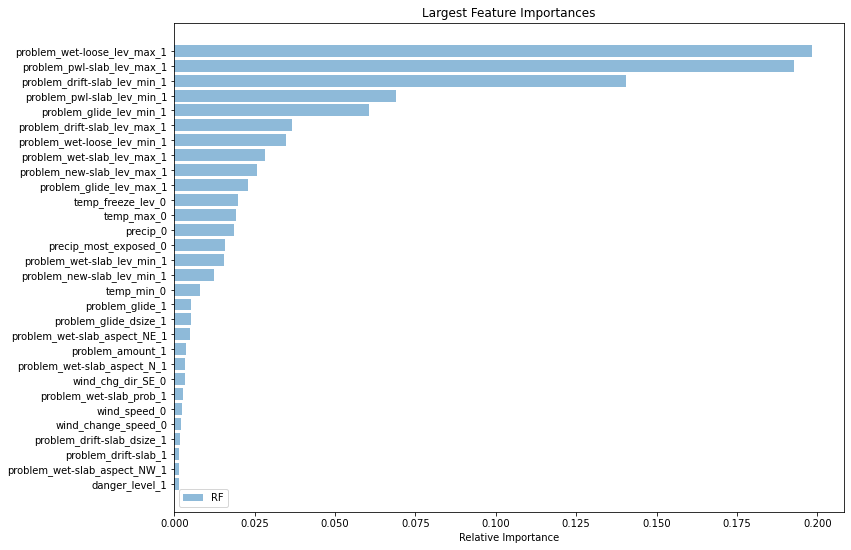

In [27]:
def plot_importances(df, labels, rf):
    """
    Input a dataframe as well as trained RandomForest model, plot feature importances.
    
    """
    columns = df.columns # all columns except the target column
    importances_rf = rf.best_estimator_.feature_importances_
    
    #take the top x feature importances to plot
    idx_all = np.argsort(importances_rf)
    idx_rf = np.argsort(importances_rf)[-30:]
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    #random forest and xgboost feature importances on the same plot
    ax.barh(range(len(idx_rf)), importances_rf[idx_rf], color='tab:blue', align='center', alpha=0.5, label='RF')
    
    ax.set_yticks(range(len(idx_rf)))
    ax.set_yticklabels([columns[i] for i in idx_rf], fontsize=10)
    ax.set_xlabel('Relative Importance')
    ax.set_title('Largest Feature Importances')
    ax.legend()

    plt.show()
    
    #return a list of columns sorted by feature importance
    return importances_rf[idx_all][::-1], [columns[i] for i in idx_all][::-1]
    
# need to make sure this is using the "best" model by default
ranked_importances, ranked_columns = plot_importances(regions, labels, forest_model) 

In [28]:
ranked_importances[:35]

array([0.19837424, 0.19269911, 0.14044679, 0.06895739, 0.06069006,
       0.03673239, 0.03486742, 0.02815055, 0.02574457, 0.02286321,
       0.01971364, 0.01911837, 0.0185287 , 0.01584309, 0.01550869,
       0.01240574, 0.00801641, 0.00527195, 0.00522337, 0.00497485,
       0.00369492, 0.00343882, 0.00318022, 0.00273761, 0.0023549 ,
       0.00206603, 0.00163383, 0.0015521 , 0.00149566, 0.00142779,
       0.00123169, 0.00122664, 0.00121479, 0.00121061, 0.00115079])

After about index 35, the columns that the Random Forest model is splitting on have *very* little importance. Let's just keep the top 35 then for the sake of our comparison.

The Random Forest model thinks that min/max columns for each avalanche problem as well as temperature are very important, and to a lesser extent precipitation, freezing level, danger level, and wind speed.

In [29]:
keep_columns_rf = ranked_columns[:35]
keep_columns_rf

['problem_wet-loose_lev_max_1',
 'problem_pwl-slab_lev_max_1',
 'problem_drift-slab_lev_min_1',
 'problem_pwl-slab_lev_min_1',
 'problem_glide_lev_min_1',
 'problem_drift-slab_lev_max_1',
 'problem_wet-loose_lev_min_1',
 'problem_wet-slab_lev_max_1',
 'problem_new-slab_lev_max_1',
 'problem_glide_lev_max_1',
 'temp_freeze_lev_0',
 'temp_max_0',
 'precip_0',
 'precip_most_exposed_0',
 'problem_wet-slab_lev_min_1',
 'problem_new-slab_lev_min_1',
 'temp_min_0',
 'problem_glide_1',
 'problem_glide_dsize_1',
 'problem_wet-slab_aspect_NE_1',
 'problem_amount_1',
 'problem_wet-slab_aspect_N_1',
 'wind_chg_dir_SE_0',
 'problem_wet-slab_prob_1',
 'wind_speed_0',
 'wind_change_speed_0',
 'problem_drift-slab_dsize_1',
 'problem_drift-slab_1',
 'problem_wet-slab_aspect_NW_1',
 'danger_level_1',
 'problem_wet-slab_dist_1',
 'problem_pwl-slab_1',
 'problem_drift-slab_dist_1',
 'temp_lev_0',
 'problem_drift-slab_trig_1']

# Recursive Feature Elimination

We can also use several different models to evaluate or rank input feature importance by slowly eliminating features from a model and seeing how that affects performance. This is called recursive feature elimination. To learn more about how this is implemented in Scikit-Learn, please see [this](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) link.

- https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [54]:
# let's time the whole process
start = time.time()

# create the RFE object
#svc = SVC(kernel="linear", C=1)
lr = LinearRegression()
#lr = sklearn.linear_model.LogisticRegression()
#sgd = SGDClassifier()
#rtc = RandomForestRegression()
model = lr

n_features = 50
rfe = RFE(estimator=model, n_features_to_select=n_features, step=5, verbose=0)

# X and y were defined in the previous section on feature importances
print('Starting RFE to select top {} features.'.format(n_features))
#rfe.fit(X, y.iloc[:, 0])
rfe.fit(X, y)

end = time.time()
total_time = end - start
print('RFE took {}s with a {} model'.format(total_time, model))

Starting RFE to select top 50 features.
RFE took 3.0548689365386963s with a LinearRegression() model


**^^ so we would have to do this for every output target column.**

I am not sure of a good way to do this automatically, and it would also take a **very** long time if we were using something like a SVM.

##### Look at https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV for automating number of features selected

In [55]:
# the estimated best features have a ranking of 1
rfe.ranking_

array([23, 23, 18,  2, 10, 13, 12, 13, 12,  6,  8,  1,  9, 14, 26, 27, 29,
       30, 28, 29, 30, 30, 29, 29, 29, 28,  1,  1,  1, 30,  1,  1,  1,  1,
        1,  1,  1,  1,  1, 12, 14, 18, 19, 26, 27, 31, 30, 31, 32, 31, 31,
       32, 32, 32, 31,  1,  1,  1,  1,  1,  3,  2, 11, 10,  6,  1, 11, 11,
       21, 22, 21, 18, 27, 26,  4, 34, 33,  4, 33, 34, 35, 33, 34, 33, 36,
        8,  1, 32,  2, 19, 17, 20, 19, 13, 18, 16, 16, 24, 21, 23, 24, 26,
       26,  2, 34, 35,  3,  3, 33, 35, 37, 34, 35, 36, 10, 35, 36,  8, 21,
       23, 22, 22, 19, 12, 20, 22, 20, 19, 20, 21, 25, 25, 36,  1,  1, 37,
       37,  1,  1,  1, 38, 37, 38,  1,  1,  1,  1, 17, 17, 17, 17, 22, 16,
        8,  7, 13, 18, 16, 20, 27, 28, 37,  1,  1,  1, 36,  1,  1,  1, 38,
        1, 38,  1,  1, 38,  1,  8,  3,  4, 10,  7,  6,  6,  9,  7, 13,  3,
        7, 27, 25, 40, 40, 39, 39, 39, 39, 40, 40,  1, 40, 39,  1,  1,  1,
        1,  1,  2,  1,  1,  7,  1,  1,  1, 24, 24, 25, 25, 24, 23, 28, 28,
        4,  4,  5,  5,  6

In [56]:
f_elim_df = pd.DataFrame(rfe.ranking_, index=X.columns, columns=['Rank']).sort_values(by='Rank',ascending=True)
f_elim_df.head(n_features)

,Rank
problem_pwl-slab_cause_facet_1,1
problem_new-loose_lev_fill_4_1,1
problem_new-loose_aspect_N_1,1
problem_new-loose_aspect_E_1,1
problem_new-loose_aspect_SE_1,1
problem_new-loose_aspect_S_1,1
problem_new-loose_aspect_SW_1,1
problem_new-loose_aspect_W_1,1
problem_new-loose_aspect_NW_1,1
problem_wet-slab_lev_fill_4_1,1


In [57]:
keep_columns_rfe = f_elim_df.index.values[:n_features]
keep_columns_rfe

array(['problem_pwl-slab_cause_facet_1', 'problem_new-loose_lev_fill_4_1',
       'problem_new-loose_aspect_N_1', 'problem_new-loose_aspect_E_1',
       'problem_new-loose_aspect_SE_1', 'problem_new-loose_aspect_S_1',
       'problem_new-loose_aspect_SW_1', 'problem_new-loose_aspect_W_1',
       'problem_new-loose_aspect_NW_1', 'problem_wet-slab_lev_fill_4_1',
       'problem_glide_lev_fill_2_1', 'problem_glide_lev_fill_3_1',
       'problem_wet-slab_lev_fill_2_1', 'problem_glide_lev_fill_4_1',
       'problem_glide_aspect_E_1', 'problem_glide_aspect_NW_1',
       'problem_glide_aspect_W_1', 'problem_glide_aspect_SW_1',
       'problem_pwl-slab_cause_hoar_1', 'problem_glide_aspect_SE_1',
       'problem_wet-loose_cause_loose_1',
       'problem_wet-loose_lev_fill_1_1', 'problem_wet-loose_lev_fill_2_1',
       'problem_wet-loose_lev_fill_3_1', 'problem_wet-loose_lev_fill_4_1',
       'problem_glide_aspect_N_1', 'problem_new-loose_lev_fill_2_1',
       'problem_new-loose_aspect_NE_1', 'p

# Table of columns to keep

In [58]:
def color_keep_cols(val):
    """
    Takes a value and returns a string with the css 
    property `'color: green'` for real values, black otherwise.
    """
    color = 'lime' if val == 'Yes' else 'red'
    return 'background-color: %s' % color

In [59]:
series_corr = pd.Series(np.ones(len(keep_columns_correlations)), index=keep_columns_correlations, name='corr')
series_pca = pd.Series(np.ones(len(keep_columns_pca)), index=keep_columns_pca, name='pca')
series_rf = pd.Series(np.ones(len(keep_columns_rf)), index=keep_columns_rf, name='f_import')
series_rfe = pd.Series(np.ones(len(keep_columns_rfe)), index=keep_columns_rfe, name='rfe')

concat_list = [series_corr, series_pca, series_rf, series_rfe]
df_keep = pd.concat(concat_list, axis=1)
df_keep.replace(1, 'Yes', inplace=True)
df_keep.replace(np.nan, 'No', inplace=True)
#df_keep.shape

recommend_keep = df_keep.style.applymap(color_keep_cols)
recommend_keep

,corr,pca,f_import,rfe
problem_drift-slab_lev_max_1,Yes,Yes,Yes,No
problem_glide_aspect_SW_1,Yes,Yes,No,Yes
problem_wet-loose_aspect_S_1,Yes,Yes,No,No
problem_glide_dist_1,Yes,No,No,No
problem_wet-slab_lev_min_1,Yes,No,Yes,No
problem_new-slab_1,Yes,Yes,No,No
problem_wet-slab_prob_1,Yes,Yes,Yes,No
problem_wet-loose_aspect_SE_1,Yes,Yes,No,No
problem_wet-slab_lev_max_1,Yes,No,Yes,No
problem_pwl-slab_lev_fill_4_1,Yes,No,No,Yes


Are there any columns that all of our models think are important?

In [60]:
corr_true = df_keep['corr'] == 'Yes'
pca_true = df_keep['pca'] == 'Yes'
fimport_true = df_keep['f_import'] == 'Yes'

corr_pca_true = np.logical_and(corr_true, pca_true)
all_true = np.logical_and(fimport_true, corr_pca_true)

df_keep[all_true]

,corr,pca,f_import,rfe
problem_drift-slab_lev_max_1,Yes,Yes,Yes,No
problem_wet-slab_prob_1,Yes,Yes,Yes,No
problem_pwl-slab_lev_min_1,Yes,Yes,Yes,No
problem_pwl-slab_1,Yes,Yes,Yes,No
problem_drift-slab_dist_1,Yes,Yes,Yes,No
problem_amount_1,Yes,Yes,Yes,No
problem_drift-slab_trig_1,Yes,Yes,Yes,No
problem_wet-slab_aspect_NE_1,Yes,Yes,Yes,No
problem_wet-slab_aspect_N_1,Yes,Yes,Yes,No
problem_new-slab_lev_max_1,Yes,Yes,Yes,No


# Comments

**Summary**: 

**Recommendations**: Based on this analysis, I would recommend...